In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

import lightgbm as lgb

In [2]:
df = pd.read_csv("../../data/accident_data_with_vehicle_data_further_cleaned_w_stations_n_non_accidents_weather_merged_cleaned.csv")

df.shape

(826155, 26)

In [3]:
# convert categorical variable into indicator variables for classification

df = pd.get_dummies(df)
df.columns

Index(['longitude', 'latitude', 'accident_severity', 'day_of_week',
       'speed_limit', 'urban_or_rural_area', 'year', 'hour', 'day_of_year',
       'cluster_1', 'vehicle_type', 'sex_of_driver', 'age_of_driver',
       'engine_capacity', 'age_of_vehicle', 'driver_home_area_type',
       'accident', 'wind_direction', 'wind_speed', 'air_temperature',
       'dewpoint', 'wetb_temp', 'rltv_hum', 'ground_state_id',
       'cld_ttl_amt_id', 'road_surface_conditions_Dry',
       'road_surface_conditions_Flood (Over 3cm of water)',
       'road_surface_conditions_Frost/Ice', 'road_surface_conditions_Snow',
       'road_surface_conditions_Wet/Damp'],
      dtype='object')

In [4]:
df.describe()

,longitude,latitude,accident_severity,day_of_week,speed_limit,urban_or_rural_area,year,hour,day_of_year,cluster_1,...,dewpoint,wetb_temp,rltv_hum,ground_state_id,cld_ttl_amt_id,road_surface_conditions_Dry,road_surface_conditions_Flood (Over 3cm of water),road_surface_conditions_Frost/Ice,road_surface_conditions_Snow,road_surface_conditions_Wet/Damp
count,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,...,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000,826155.000000
mean,-1.173145,52.360513,1.572975,4.129719,36.513487,1.333338,2009.615424,12.756951,184.691667,19348.864085,...,6.995718,8.787094,80.728542,6.541981,5.145882,0.479544,0.091461,0.096861,0.093559,0.238575
std,1.263024,1.145478,1.458771,1.919329,16.440504,0.471407,2.965950,6.072844,104.854631,15534.001501,...,4.768856,4.682591,14.110279,3.694263,2.542192,0.499582,0.288264,0.295768,0.291214,0.426213
min,-5.594397,50.042087,0.000000,1.000000,10.000000,1.000000,2005.000000,0.000000,1.000000,0.000000,...,-18.500000,-16.700000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.098174,51.505271,0.000000,3.000000,30.000000,1.000000,2007.000000,8.000000,94.000000,5117.500000,...,3.623643,5.400000,72.800000,4.000000,3.096277,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.741717,51.827608,2.000000,4.000000,30.000000,1.000000,2010.000000,13.000000,185.000000,15838.000000,...,7.200000,8.980248,83.800000,6.420101,5.826782,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.148145,53.403141,3.000000,6.000000,50.000000,2.000000,2012.000000,17.000000,277.000000,31967.000000,...,10.626062,12.339332,91.700000,9.833754,7.575949,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.756336,60.160336,3.000000,7.000000,70.000000,2.000000,2014.000000,23.000000,366.000000,54492.000000,...,24.700000,25.000000,100.000000,19.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='accident', ylabel='count'>

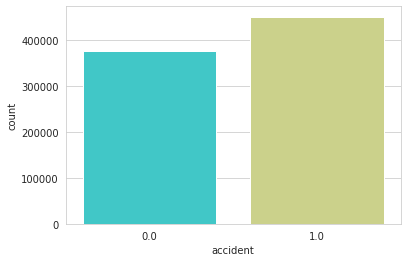

In [5]:
# both accident and non-accident sizes are balanced (un-biased)
sns.set_style('whitegrid')
sns.countplot(x='accident',data=df,palette='rainbow')

<AxesSubplot:>

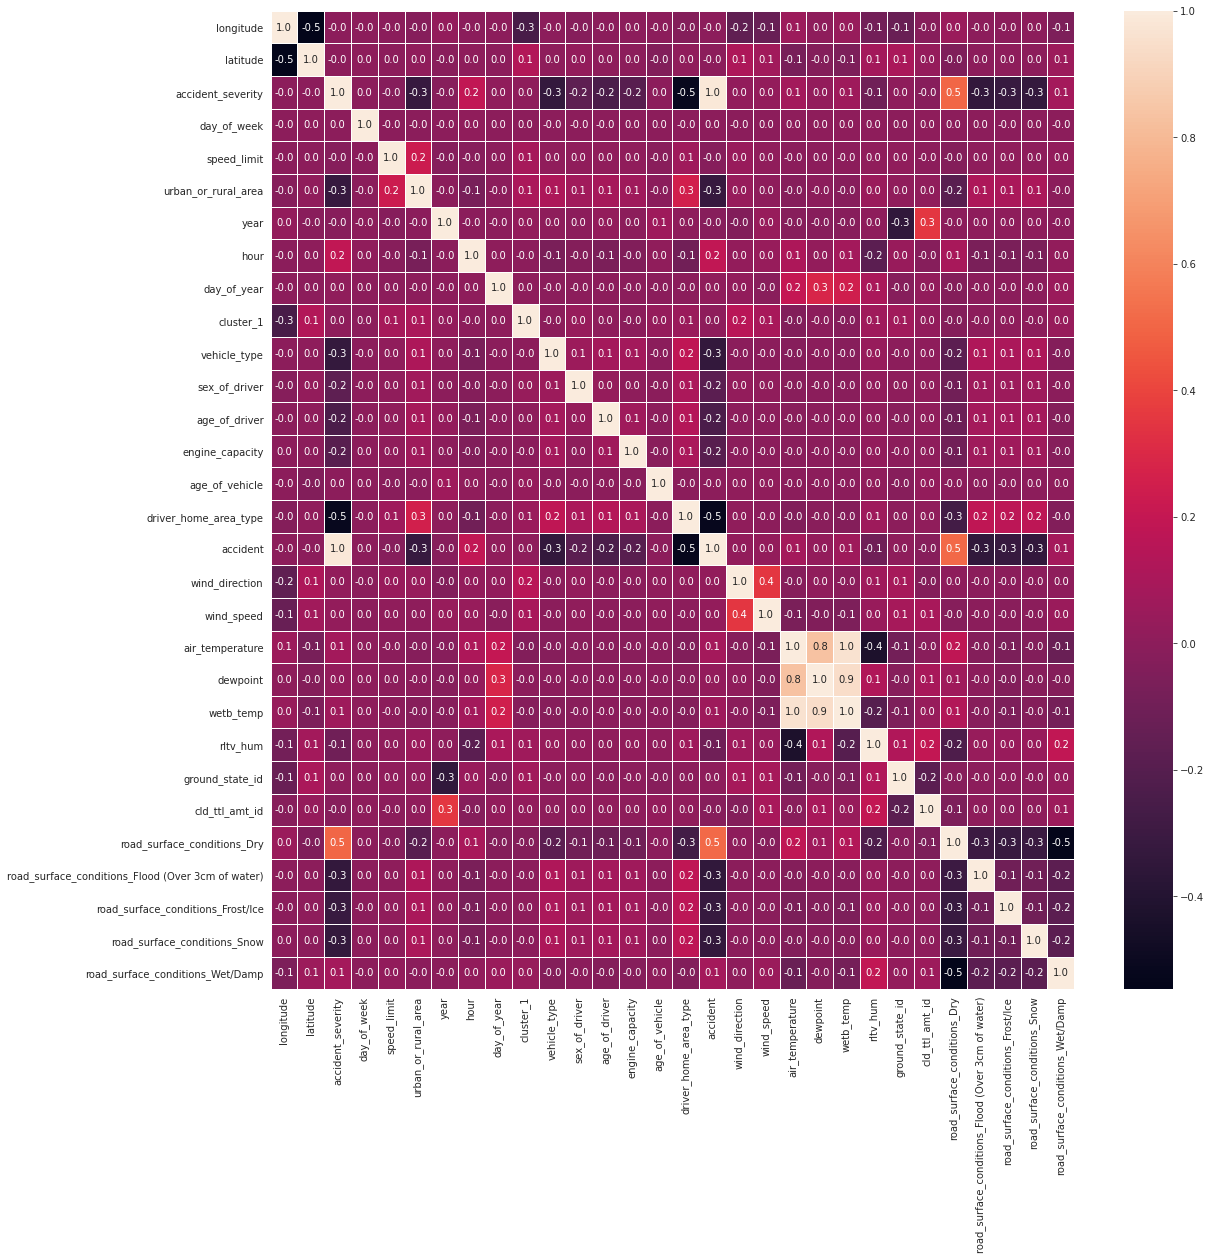

In [6]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### remove higly coorelated featrues

In [7]:
corr_matrix = df.corr().abs()
corr_matrix

,longitude,latitude,accident_severity,day_of_week,speed_limit,urban_or_rural_area,year,hour,day_of_year,cluster_1,...,dewpoint,wetb_temp,rltv_hum,ground_state_id,cld_ttl_amt_id,road_surface_conditions_Dry,road_surface_conditions_Flood (Over 3cm of water),road_surface_conditions_Frost/Ice,road_surface_conditions_Snow,road_surface_conditions_Wet/Damp
longitude,1.000000,0.547329,0.001868,0.001538,0.008878,0.027398,0.022097,0.006715,0.000816,0.256841,...,0.004810,0.034883,0.088982,0.124590,0.016156,0.048545,0.000505,0.003559,0.000043,0.054119
latitude,0.547329,1.000000,0.001578,0.003325,0.000320,0.014266,0.009761,0.004164,0.001528,0.132791,...,0.027701,0.055113,0.081110,0.102975,0.030619,0.048182,0.000575,0.004934,0.001436,0.051681
accident_severity,0.001868,0.001578,1.000000,0.000151,0.025499,0.321336,0.015775,0.185576,0.011601,0.003090,...,0.025463,0.058617,0.105094,0.005455,0.015571,0.504107,0.339963,0.314553,0.332484,0.084501
day_of_week,0.001538,0.003325,0.000151,1.000000,0.003755,0.006283,0.001247,0.013767,0.001689,0.002199,...,0.007685,0.005257,0.005897,0.001857,0.002970,0.002006,0.001053,0.003545,0.000969,0.001266
speed_limit,0.008878,0.000320,0.025499,0.003755,1.000000,0.231820,0.021575,0.017614,0.001064,0.089998,...,0.001840,0.002434,0.012785,0.013722,0.001955,0.029716,0.008561,0.010610,0.008687,0.015743
urban_or_rural_area,0.027398,0.014266,0.321336,0.006283,0.231820,1.000000,0.006312,0.073390,0.003284,0.110237,...,0.001770,0.016817,0.045828,0.013675,0.009354,0.185359,0.113077,0.105285,0.109553,0.007127
year,0.022097,0.009761,0.015775,0.001247,0.021575,0.006312,1.000000,0.004314,0.000359,0.024931,...,0.018800,0.020250,0.008297,0.343442,0.347679,0.002749,0.005409,0.006371,0.006235,0.009119
hour,0.006715,0.004164,0.185576,0.013767,0.017614,0.073390,0.004314,1.000000,0.004640,0.000874,...,0.022434,0.078804,0.181914,0.041182,0.023170,0.098494,0.065899,0.066386,0.059515,0.015854
day_of_year,0.000816,0.001528,0.011601,0.001689,0.001064,0.003284,0.000359,0.004640,1.000000,0.003683,...,0.280865,0.245016,0.101938,0.026688,0.016651,0.031763,0.004834,0.003621,0.007588,0.048198
cluster_1,0.256841,0.132791,0.003090,0.002199,0.089998,0.110237,0.024931,0.000874,0.003683,1.000000,...,0.002435,0.023776,0.064316,0.071477,0.019453,0.030428,0.000506,0.002823,0.001130,0.034821


In [8]:
corr = corr_matrix.abs().unstack()
corr

longitude                         longitude                                            1.000000
                                  latitude                                             0.547329
                                  accident_severity                                    0.001868
                                  day_of_week                                          0.001538
                                  speed_limit                                          0.008878
                                                                                         ...   
road_surface_conditions_Wet/Damp  road_surface_conditions_Dry                          0.537306
                                  road_surface_conditions_Flood (Over 3cm of water)    0.177601
                                  road_surface_conditions_Frost/Ice                    0.183314
                                  road_surface_conditions_Snow                         0.179834
                                  road_s

In [9]:
labels_to_drop = set()
cols = df.columns
for i in range(0, df.shape[1]):
    for j in range(0, i+1):
        labels_to_drop.add((cols[i], cols[j]))

corr = corr.drop(labels=labels_to_drop).sort_values(ascending=False)

# top correlated pairs
corr[0:15]

accident_severity            accident                                             0.985311
air_temperature              wetb_temp                                            0.963065
dewpoint                     wetb_temp                                            0.944878
air_temperature              dewpoint                                             0.831295
longitude                    latitude                                             0.547329
road_surface_conditions_Dry  road_surface_conditions_Wet/Damp                     0.537306
driver_home_area_type        accident                                             0.522525
accident_severity            driver_home_area_type                                0.516369
accident                     road_surface_conditions_Dry                          0.512574
accident_severity            road_surface_conditions_Dry                          0.504107
air_temperature              rltv_hum                                             0.432334

In [10]:
# remove labels with coorelation > .95
to_drop = ['accident_severity','wetb_temp']

# drop features 
df.drop(to_drop, axis=1, inplace=True)

In [11]:
df.columns

Index(['longitude', 'latitude', 'day_of_week', 'speed_limit',
       'urban_or_rural_area', 'year', 'hour', 'day_of_year', 'cluster_1',
       'vehicle_type', 'sex_of_driver', 'age_of_driver', 'engine_capacity',
       'age_of_vehicle', 'driver_home_area_type', 'accident', 'wind_direction',
       'wind_speed', 'air_temperature', 'dewpoint', 'rltv_hum',
       'ground_state_id', 'cld_ttl_amt_id', 'road_surface_conditions_Dry',
       'road_surface_conditions_Flood (Over 3cm of water)',
       'road_surface_conditions_Frost/Ice', 'road_surface_conditions_Snow',
       'road_surface_conditions_Wet/Damp'],
      dtype='object')

### data split

In [12]:
all_feature_cols = list(df.columns)
all_feature_cols.remove('accident')

X = df[all_feature_cols] 
y = df['accident']

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('X_train dimension = ', X_train.shape)
print('X_test  dimension = ', X_test.shape)
print('y_train dimension = ', y_train.shape)
print('y_train dimension = ', y_test.shape)

X_train dimension =  (578308, 27)
X_test  dimension =  (247847, 27)
y_train dimension =  (578308,)
y_train dimension =  (247847,)


### Feature selection with feature importance

In [13]:
feature_importances = np.zeros(X_train.shape[1])

model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 10000, 
                           class_weight = 'balanced')

In [14]:
model.fit(X_train, 
          y_train, 
          early_stopping_rounds=100, 
          eval_set = [(X_test, y_test)], 
          eval_metric = 'auc', 
          verbose = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.999637	valid_0's binary_logloss: 0.020287
[400]	valid_0's auc: 0.999705	valid_0's binary_logloss: 0.0177475
[600]	valid_0's auc: 0.99973	valid_0's binary_logloss: 0.016698
[800]	valid_0's auc: 0.999743	valid_0's binary_logloss: 0.0161207
[1000]	valid_0's auc: 0.999746	valid_0's binary_logloss: 0.0158567
[1200]	valid_0's auc: 0.999754	valid_0's binary_logloss: 0.0156126
Early stopping, best iteration is:
[1291]	valid_0's auc: 0.999756	valid_0's binary_logloss: 0.0155629


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [15]:
feature_importances = model.feature_importances_ 
feature_importances = pd.DataFrame(
    {'feature': all_feature_cols, 
     'importance': feature_importances}
).sort_values('importance', ascending = False)
feature_importances

,feature,importance
12,engine_capacity,5441
9,vehicle_type,2937
11,age_of_driver,2504
0,longitude,2375
1,latitude,2349
8,cluster_1,2161
7,day_of_year,1922
19,rltv_hum,1728
17,air_temperature,1529
6,hour,1527


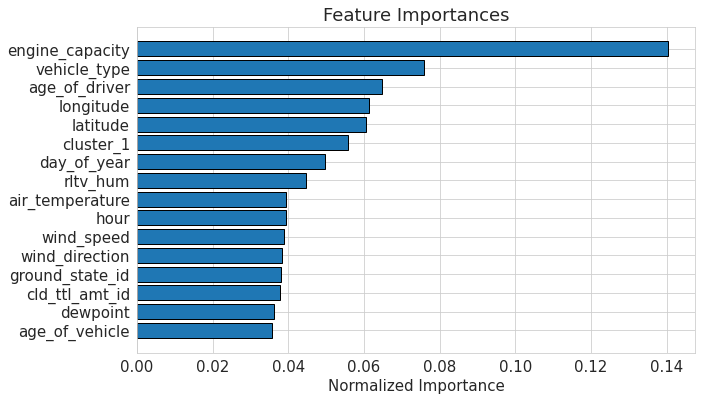

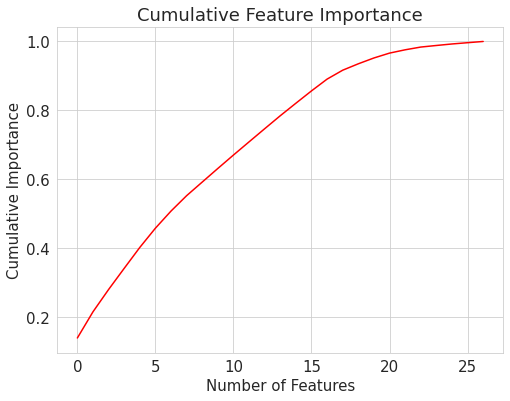

20 features required for 0.95 of cumulative importance


In [16]:
# select top 16 features
def plot_feature_importances(df, threshold = 0.9):    
    plt.rcParams['font.size'] = 15
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:16]))), 
            df['importance_normalized'].head(16), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:16]))))
    ax.set_yticklabels(df['feature'].head(16))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [17]:
# top features

top_feature_cols = list((feature_importances).feature[0:16])
top_feature_cols

['engine_capacity',
 'vehicle_type',
 'age_of_driver',
 'longitude',
 'latitude',
 'cluster_1',
 'day_of_year',
 'rltv_hum',
 'air_temperature',
 'hour',
 'wind_speed',
 'wind_direction',
 'ground_state_id',
 'cld_ttl_amt_id',
 'dewpoint',
 'age_of_vehicle']

In [18]:
classification_ready_features = top_feature_cols
classification_ready_features.append('accident')

In [19]:
classification_ready_data = df[classification_ready_features]
classification_ready_data.sample(6)

,engine_capacity,vehicle_type,age_of_driver,longitude,latitude,cluster_1,day_of_year,rltv_hum,air_temperature,hour,wind_speed,wind_direction,ground_state_id,cld_ttl_amt_id,dewpoint,age_of_vehicle,accident
239061,2972.0,21.0,63.0,-2.948497,53.404118,7750.0,259.0,96.500000,13.000000,8.0,5.000000,70.000000,9.985696,7.000000,12.400000,7.0,0.0
332797,1870.0,9.0,43.0,-0.158199,51.905651,21788.0,151.0,73.630267,15.520789,11.0,10.406191,113.079574,5.964956,5.157108,10.843739,8.0,1.0
417263,981.0,19.0,87.0,-0.407707,51.483873,3964.0,314.0,87.000000,4.700000,8.0,7.000000,290.000000,1.000000,0.000000,2.800000,12.0,0.0
780295,1149.0,9.0,30.0,-1.996201,53.460738,8843.0,92.0,89.900000,7.600000,18.0,12.000000,280.000000,9.000271,7.000000,6.100000,3.0,1.0
554957,2204.0,4.0,8.0,-0.033877,51.512373,1169.0,280.0,94.228304,6.895773,7.0,7.861218,194.607884,5.964958,7.492543,5.969682,11.0,0.0
14734,827.0,19.0,1.0,-1.545620,52.418079,16441.0,27.0,90.348344,6.067584,9.0,8.837967,276.178800,1.362103,7.052564,4.578251,7.0,0.0


In [20]:
classification_ready_data.shape

(826155, 17)

In [21]:
classification_ready_data.to_csv("../../data/classification_ready_data.csv", index=False)